In [1]:
!pip install tensorflow
!pip show tensorflow



Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt




In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Dataset/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


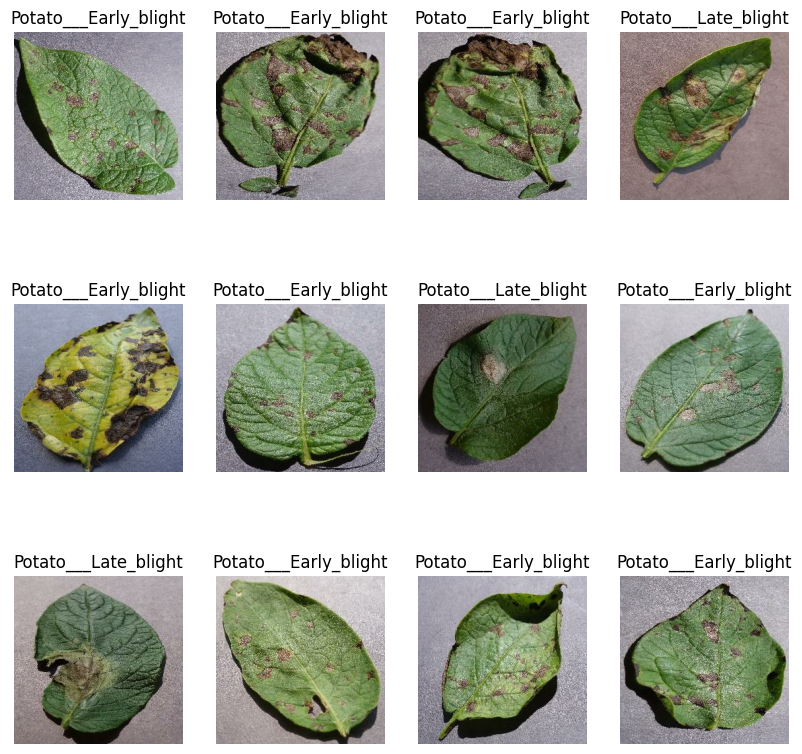

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        #This line of code extracts the i-th image from a batch (image_batch), converts it into a NumPy
        # array,(as matplotlib works with numpy array) ensures it has the correct data type (uint8), and then displays it using matplotlib.
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)
  #Shuffling ensures that the data is randomized before splitting(larger values improve randomness).)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [10]:
len(train_ds)

54

In [11]:
len(val_ds)

6

In [12]:
len(test_ds)

8

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# cache() ensures data is loaded into memory once, preventing repeated loading from disk while running second epoch
# shuffle(1000) ensures randomness in data ordering, which is important for training.
# prefetch(buffer_size=tf.data.AUTOTUNE)  method allows TensorFlow to pre-load the next batch of data
# while the current batch is being processed.
# buffer_size=tf.data.AUTOTUNE allows TensorFlow to automatically adjust the prefetch buffer size based on
# the system's memory and performance.

In [14]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [16]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),  # Define input shape explicitly
    resize_and_rescale,  # Preprocessing layer
    data_augmentation,   # Preprocessing layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [17]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,363 (56.61 MB)

 Trainable params: 14,839,363 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 352s 6s/step - accuracy: 0.5898 - loss: 1.2707 - val_accuracy: 0.7760 - val_loss: 0.5472
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 348s 6s/step - accuracy: 0.8439 - loss: 0.4656 - val_accuracy: 0.7135 - val_loss: 0.5725
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - accuracy: 0.8518 - loss: 0.3867 - val_accuracy: 0.8177 - val_loss: 0.3809
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 331s 6s/step - accuracy: 0.8993 - loss: 0.2520 - val_accuracy: 0.9167 - val_loss: 0.2078
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 316s 6s/step - accuracy: 0.9181 - loss: 0.2079 - val_accuracy: 0.9375 - val_loss: 0.1667
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 320s 6s/step - accuracy: 0.9445 - loss: 0.1506 - val_accuracy: 0.9271 - val_loss: 0.1624
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 311s 6s/step - accuracy: 0.9320 - loss: 0.1826 - val_accuracy: 0.9115 - val_loss: 0.2151
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 318s 6s/step - accuracy: 0.9524 - loss: 0.1379 - val_accuracy: 0.9792 - v

In [20]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9598 - loss: 0.1057


In [21]:
scores

[0.11864416301250458, 0.953125]

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [24]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

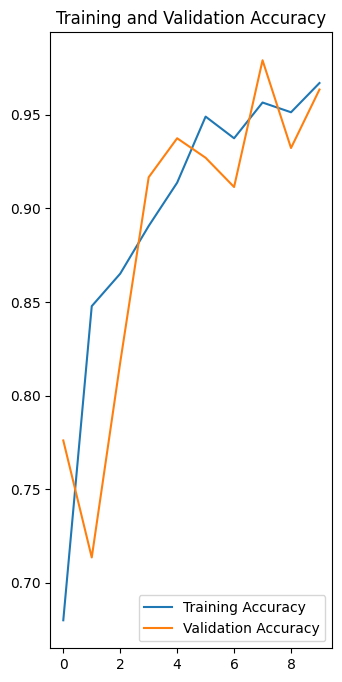

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



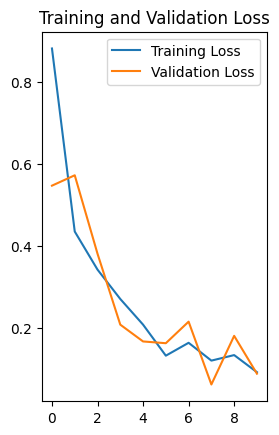

In [28]:
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
predicted_label: Potato___Late_blight


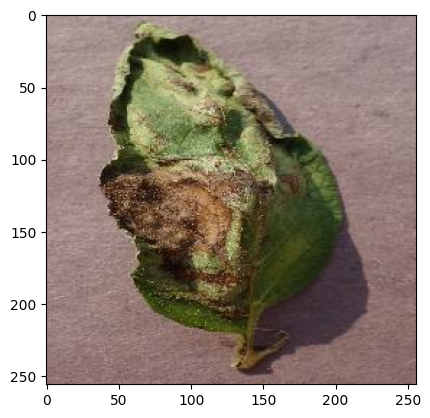

In [31]:
import numpy as np  # Ensure this is included
import matplotlib.pyplot as plt  # If not already imported

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8') #first image from the first batch
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("predicted_label:", class_names[np.argmax(batch_prediction[0])]) #it will return result in 3 dimension because output has n_classes = 3
    # we do np.argmax to get the max value which (whichever class has highest value that is only the actual class)

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) #converting images to numpy array
    img_array = tf.expand_dims(img_array,0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(batch_prediction[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


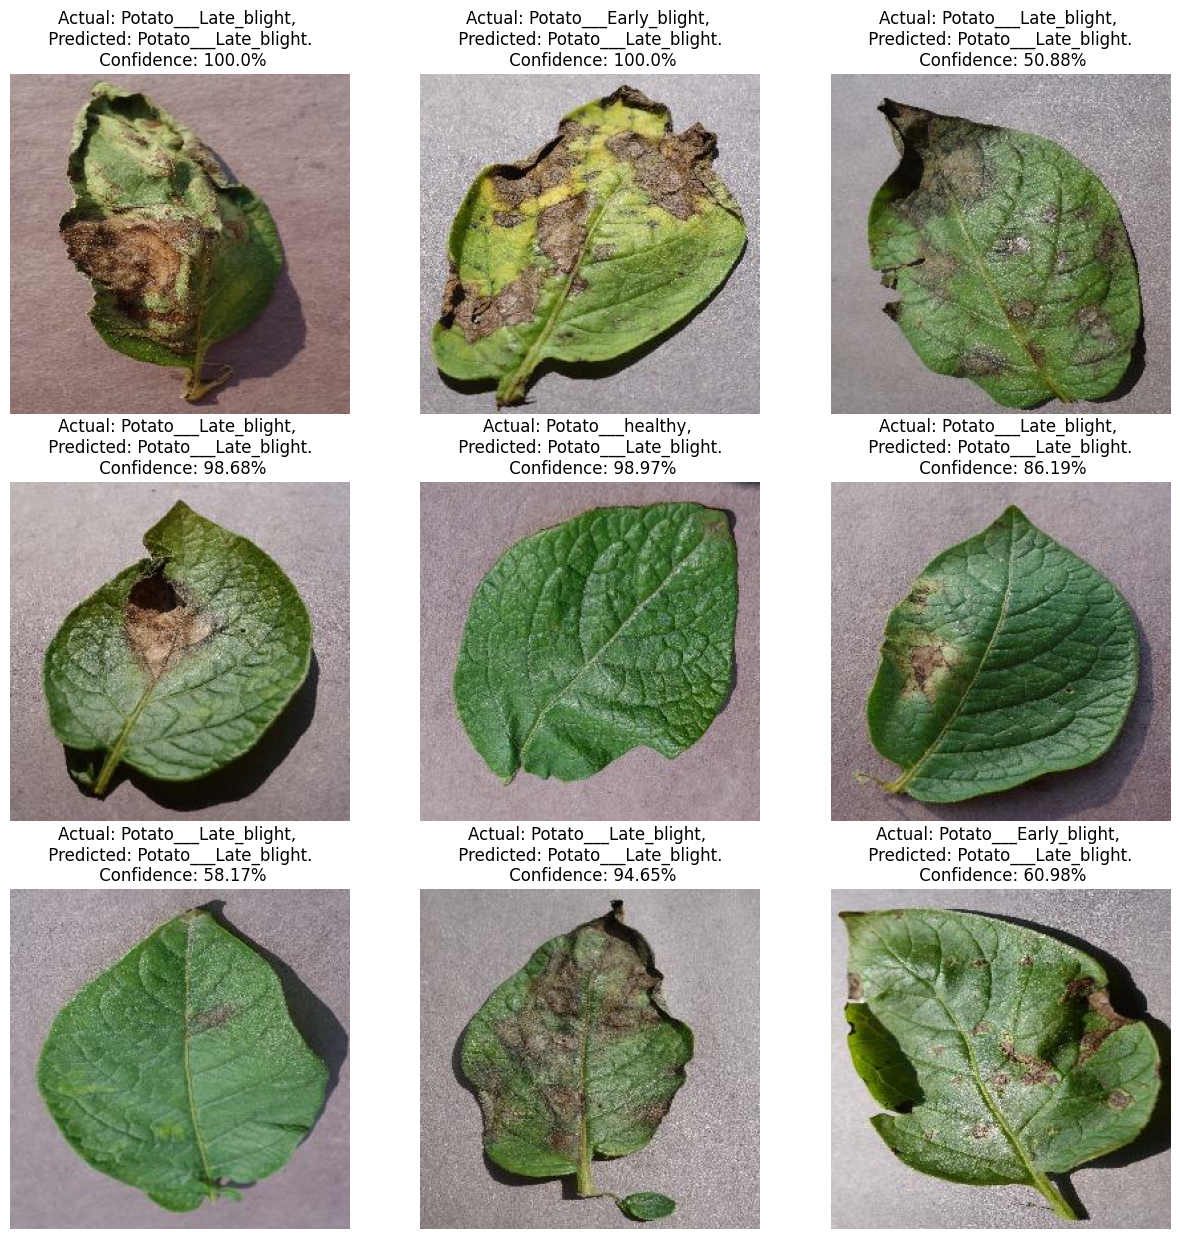

In [33]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis("off")


In [39]:
model_version = 1
model.save(f"/content/drive/MyDrive/Colab Dataset/models/model_v{model_version}.keras")
